# Train 19-train_RNN_RNN_Wikipedia_geo_ratio_sc_0.5

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from rouge_score import rouge_scorer

from utils_french_sum_ner.EmbMgr import EmbMgr
from utils_french_sum_ner.Dataset import Dataset
from utils_french_sum_ner.DataLoader import DataLoader
from utils_french_sum_ner.preprocess_df import preprocess_df
from utils_french_sum_ner.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils_french_sum_ner.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn
from utils_french_sum_ner.split_all_docs import split_all_docs

from models.RNN_RNN import RNN_RNN

from time import time

import json
import argparse

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [4]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=1)
parser.add_argument('-batch_size',type=int,default=8)
parser.add_argument('-epochs',type=int,default=100)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [5]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "cc.fr.300.vec"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
early_stopping = 3
model_name = "21-train_RNN_RNN_OnlyNER_Wikipedia_geo_ratio_sc_0.5"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_number_of_sentences_per_document = 3
loss_sum_coef = 0.5
loss_ner_coef = 0.5

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 1
epochs 100
batch_size 8


## PyTorch initialisation

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 5
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080
GPU 3: NVIDIA GeForce GTX 1080
GPU 4: NVIDIA GeForce GTX 1080


/home/raoufdine/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=1)

## Chargement des données

In [8]:
embmgr = EmbMgr("./data/cc.fr.300.vec", vocab_size=vocab_size, header=True)

In [9]:

df_train = pd.read_json("./data/wiki_geo_ratio_sc_0.5/train.json")
train_dataset = Dataset(preprocess_df(df_train, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", labels_ner_col_name="labels_entities", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
df_val = pd.read_json("./data/wiki_geo_ratio_sc_0.5/val.json")
val_dataset = Dataset(preprocess_df(df_val, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", labels_ner_col_name="labels_entities", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [11]:
df_test = pd.read_json("./data/wiki_geo_ratio_sc_0.5/test.json")
test_dataset = Dataset(preprocess_df(df_test, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", labels_ner_col_name="labels_entities", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Model

In [12]:
from models.BasicModel import BasicModel
import torch
import torch.nn as nn
import torch.nn.functional as F

class RNN_RNN(BasicModel):
    def __init__(self, device, vocab_size, word_embed = None, dim_word_embed = 100):
        super(RNN_RNN, self).__init__(device)

        self.device = device

        self.word_embedding = nn.Embedding(vocab_size+2, dim_word_embed, padding_idx=0)
        # Load word embedding if specified
        if word_embed is not None:
            self.word_embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(word_embed).float())

        # 100 : word2vec embedding size
        self.word_GRU = nn.GRU(input_size = dim_word_embed, hidden_size = 200, batch_first = True, bidirectional = True)
        self.sent_GRU = nn.GRU(input_size = 2*200, hidden_size=200, batch_first = True, bidirectional = True)

        # 10: relative position range size, with segment size = 10
        self.rel_pos_emb = nn.Embedding(11, 100)
        self.abs_pos_emb = nn.Embedding(100, 100)

        self.Wdoc = nn.Linear(2*200,2*200,bias=True)

        self.Wcontent = nn.Linear(2*200,1,bias=False)
        self.Wsalience = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wnovelty = nn.Bilinear(2*200,2*200,1,bias=False)
        self.Wabs_pos = nn.Linear(100,1,bias=False)
        self.Wrel_pos = nn.Linear(100,1,bias=False)
        self.bias = nn.Parameter(torch.empty(1).uniform_(-0.1, 0.1))

        self.w_ner = nn.Linear(400, 1)

    def avg_pool1d(self,x,seq_lens):
        out = []
        for index,t in enumerate(x):
            if seq_lens[index] == 0:
                t = t[:1]
            else:
                t = t[:seq_lens[index],:]
            t = torch.t(t).unsqueeze(0)
            out.append(F.avg_pool1d(t,t.size(2)))
        
        out = torch.cat(out).squeeze(2)
        return out

    def forward(self, arr_x, doc_lens):
        probs = []

        original_arr_x = arr_x

        max_doc_lens = max(doc_lens)
        sent_lens = torch.sum(torch.sign(arr_x),dim=1).data

        arr_x = self.word_embedding(arr_x)
        arr_x = self.word_GRU(arr_x)[0]

        o_ner = arr_x
        o_ner = o_ner.reshape(-1, arr_x.size(-1))[original_arr_x.view(-1) != 0, :]
        o_ner = torch.sigmoid(self.w_ner(o_ner)).squeeze(-1)

        arr_x = self.avg_pool1d(arr_x, sent_lens)

        arr_x = self.pad_doc(arr_x, doc_lens)

        arr_x = self.sent_GRU(arr_x)[0]
        sents_all_docs = arr_x.reshape(len(doc_lens) * max_doc_lens, 2*200) # flat docs
        
        docs = self.avg_pool1d(arr_x, doc_lens)
        docs = torch.tanh(self.Wdoc(docs))
        docs_for_each_sent = docs.repeat_interleave(max_doc_lens, dim=0) # repeat doc n times
        
        contents = self.Wcontent(sents_all_docs)
        saliences = self.Wsalience(sents_all_docs, docs_for_each_sent)

        # Compute position embedding
        abs_poses = torch.tensor([[position] for position in range(max_doc_lens)], dtype=torch.long)
        abs_poses = abs_poses.to(self.device)
        abs_poses = self.abs_pos_emb(abs_poses).squeeze(1)
        aps = self.Wabs_pos(abs_poses)

        # Compute relative position embedding
        rel_poses = torch.tensor([[int(round(position / 10))] for position in range(max_doc_lens)], dtype=torch.long)
        rel_poses = rel_poses.to(self.device)
        rel_poses = self.rel_pos_emb(rel_poses).squeeze(1)
        rps = self.Wrel_pos(rel_poses)

        # doc_len (number) s
        ses = torch.zeros(len(doc_lens), 2*200)
        ses = ses.to(self.device)

        # for each document, compute probabilities
        for position in range(max_doc_lens):
            contents_for_position = contents[position::max_doc_lens]
            saliences_for_position = saliences[position::max_doc_lens]
            novelties_for_position = -1 * self.Wnovelty(sents_all_docs[position::max_doc_lens], torch.tanh(ses))
            prob = contents_for_position + saliences_for_position + novelties_for_position + aps[position] + rps[position] + self.bias
            prob = torch.sigmoid(prob)
            probs.append(prob)

            ses = ses + torch.mul(sents_all_docs[position::max_doc_lens], prob)
        probs = torch.cat(probs).squeeze()
        if len(probs.shape) == 0:
            probs = probs.unsqueeze(0)
        probs_filtered = []
        for idx, doc_len in enumerate(doc_lens):
            prob = probs[idx::len(doc_lens)]
            prob = prob[:doc_len]
            probs_filtered.append(prob)
        probs_filtered = torch.cat(probs_filtered).squeeze()
        if len(probs_filtered.shape) == 0:
            probs_filtered = probs_filtered.unsqueeze(0)
        #probs = probs.to(self.device)
        return probs_filtered, o_ner

In [13]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings(), dim_word_embed=300)

In [14]:
model.to(device)

RNN_RNN(
  (word_embedding): Embedding(150001, 300)
  (word_GRU): GRU(300, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
  (w_ner): Linear(in_features=400, out_features=1, bias=True)
)

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
mae_fn = nn.L1Loss()

## Train

In [16]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [17]:
df_val["doc_splitted"] = split_all_docs(df_val["flat_contents"], is_sep_n = False)
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [18]:
arr_train_loss = []
arr_train_loss_sum = []
arr_train_loss_ner = []
arr_train_mae = []
arr_train_acc = []
arr_train_acc_ner = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []
arr_val_acc_ner = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    total_train_loss_sum = 0
    total_train_loss_ner = 0
    total_train_acc_ner = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["docs"]))
                features = features + batch[j]["docs"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            #targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            #targets = torch.cat(targets)
            #targets = targets.to(device)

            targets_ner = [torch.tensor(batch[j]["labels_ner"][k], dtype=torch.float) for j in range(batch_size) for k in range(len(batch[j]["labels_ner"]))]
            targets_ner = torch.cat(targets_ner)
            targets_ner = targets_ner.to(device)

            probs, y_ner_pred = model(features, doc_lens)
            
            #loss_sum = loss_fn(probs, targets)
            loss_ner = loss_fn(y_ner_pred, targets_ner)

            loss = loss_ner # loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            nb_batch_train += 1
            total_train_loss += loss.item()
            #total_train_loss_sum += loss_sum.item()
            total_train_loss_ner += loss_ner.item()
            #total_train_mae += mae_fn(probs, targets).item()
            #total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
            total_train_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, loss_ner=total_train_loss_ner/nb_batch_train, accuracy_ner=total_train_acc_ner/nb_batch_train)

    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0
    total_val_loss_sum = 0
    total_val_loss_ner = 0
    total_val_acc_ner = 0
    total_r1 = 0
    total_r2 = 0
    total_rl = 0

    for i, batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        #targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        #targets = torch.cat(targets)
        #targets = targets.to(device)

        targets_ner = [torch.tensor(batch[j]["labels_ner"][k], dtype=torch.float) for j in range(1) for k in range(len(batch[j]["labels_ner"]))]
        targets_ner = torch.cat(targets_ner)
        targets_ner = targets_ner.to(device)

        y_pred, y_ner_pred = model(features, doc_lens)
        
        #loss_sum = loss_fn(y_pred, targets)
        loss_ner = loss_fn(y_ner_pred, targets_ner)

        loss = loss_ner # loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

        nb_batch_val += 1
        total_val_loss += loss.item()
        #total_val_loss_sum += loss_sum.item()
        total_val_loss_ner += loss_ner.item()

        total_val_acc_ner += torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0]

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_acc_ner.append(total_train_acc_ner / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_acc_ner.append(total_val_acc_ner / nb_batch_val)
    
    print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

    if len(arr_val_loss) >= early_stopping+1:
        if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
            break

    # update lr
    scheduler.step()

t2 = time()
print("Training duration =", t2-t1)

Epoch 1: 100%|██████████| 13/13 [00:01<00:00,  8.39batch/s, accuracy_ner=0.842, loss=0.503, loss_ner=0.503]


Epoch 1 : val loss = 0.367, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  8.50batch/s, accuracy_ner=0.894, loss=0.344, loss_ner=0.344]


Epoch 2 : val loss = 0.361, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  9.24batch/s, accuracy_ner=0.897, loss=0.328, loss_ner=0.328]


Epoch 3 : val loss = 0.359, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  9.33batch/s, accuracy_ner=0.898, loss=0.325, loss_ner=0.325]


Epoch 4 : val loss = 0.358, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  8.87batch/s, accuracy_ner=0.897, loss=0.326, loss_ner=0.326]


Epoch 5 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  9.05batch/s, accuracy_ner=0.897, loss=0.325, loss_ner=0.325]


Epoch 6 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  9.13batch/s, accuracy_ner=0.895, loss=0.33, loss_ner=0.33]  


Epoch 7 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  9.21batch/s, accuracy_ner=0.897, loss=0.324, loss_ner=0.324]


Epoch 8 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 9: 100%|██████████| 13/13 [00:01<00:00,  9.65batch/s, accuracy_ner=0.898, loss=0.322, loss_ner=0.322]


Epoch 9 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  9.45batch/s, accuracy_ner=0.896, loss=0.327, loss_ner=0.327]


Epoch 10 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  9.42batch/s, accuracy_ner=0.896, loss=0.327, loss_ner=0.327]


Epoch 11 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 12: 100%|██████████| 13/13 [00:01<00:00,  9.34batch/s, accuracy_ner=0.897, loss=0.325, loss_ner=0.325]


Epoch 12 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 13: 100%|██████████| 13/13 [00:01<00:00,  8.58batch/s, accuracy_ner=0.894, loss=0.331, loss_ner=0.331]


Epoch 13 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  8.87batch/s, accuracy_ner=0.895, loss=0.327, loss_ner=0.327]


Epoch 14 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 15: 100%|██████████| 13/13 [00:01<00:00,  9.22batch/s, accuracy_ner=0.896, loss=0.326, loss_ner=0.326]


Epoch 15 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 16: 100%|██████████| 13/13 [00:01<00:00,  8.88batch/s, accuracy_ner=0.892, loss=0.334, loss_ner=0.334]


Epoch 16 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 17: 100%|██████████| 13/13 [00:01<00:00,  9.07batch/s, accuracy_ner=0.893, loss=0.331, loss_ner=0.331]


Epoch 17 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 18: 100%|██████████| 13/13 [00:01<00:00,  9.05batch/s, accuracy_ner=0.896, loss=0.326, loss_ner=0.326]


Epoch 18 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 19: 100%|██████████| 13/13 [00:01<00:00,  8.79batch/s, accuracy_ner=0.894, loss=0.33, loss_ner=0.33]  


Epoch 19 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 20: 100%|██████████| 13/13 [00:01<00:00,  8.88batch/s, accuracy_ner=0.896, loss=0.327, loss_ner=0.327]


Epoch 20 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 21: 100%|██████████| 13/13 [00:01<00:00,  9.34batch/s, accuracy_ner=0.9, loss=0.318, loss_ner=0.318]  


Epoch 21 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 22: 100%|██████████| 13/13 [00:01<00:00,  8.56batch/s, accuracy_ner=0.896, loss=0.326, loss_ner=0.326]


Epoch 22 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000


Epoch 23: 100%|██████████| 13/13 [00:01<00:00,  9.02batch/s, accuracy_ner=0.895, loss=0.328, loss_ner=0.328]


Epoch 23 : val loss = 0.357, val mae = 0.000, val accuracy = 0.000, r1 = 0.000, r2 = 0.000, rL = 0.000
Training duration = 96.55654907226562


In [19]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["train_acc_ner"] = arr_train_acc_ner
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc
training_metrics["val_acc_ner"] = arr_val_acc_ner

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

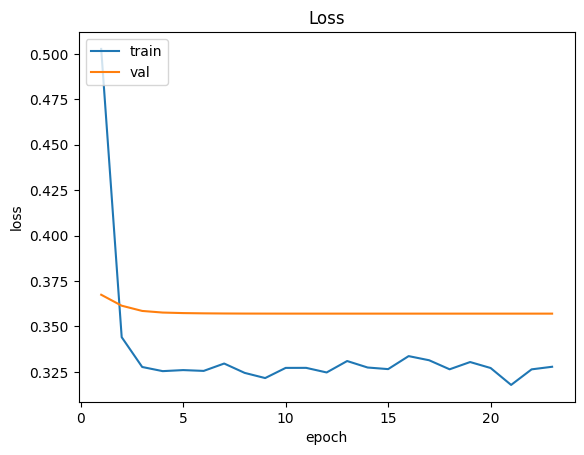

In [20]:
# draw Losses
if is_graphic:
    plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
    plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper left")

    plt.show()

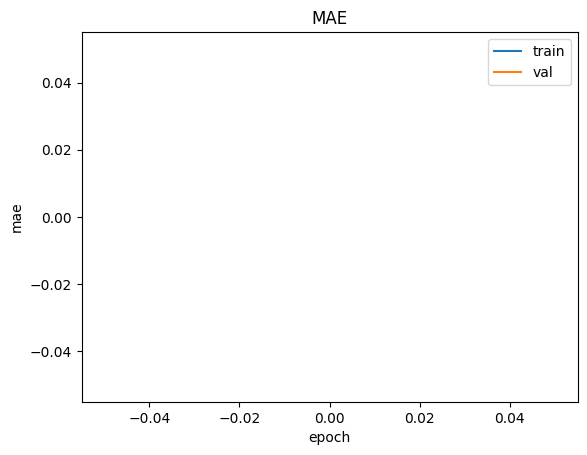

In [21]:
# draw mae
if is_graphic:
    plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
    plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

    plt.title("MAE")
    plt.xlabel("epoch")
    plt.ylabel("mae")
    plt.legend(loc="upper right")

    plt.show()

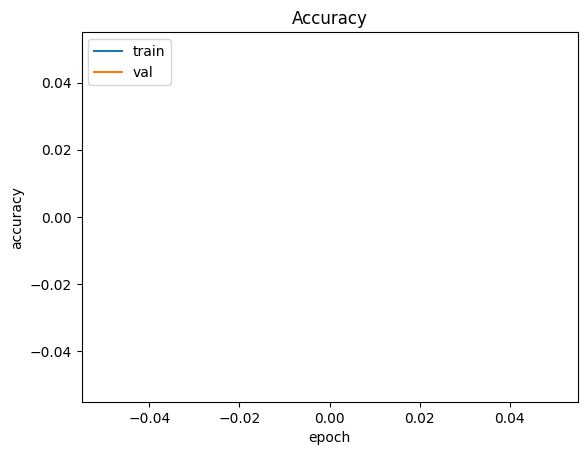

In [22]:
# draw Accuracies
if is_graphic:
    plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
    plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="upper left")

    plt.show()

# Eval model

In [23]:
from utils_french.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils_french.threshold_probs import threshold_probs_by_prop

In [24]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings(), dim_word_embed=300)

In [25]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

20

In [26]:
test_set = df_test
test_set["doc_splited"] = split_all_docs(test_set["flat_contents"], False)

In [27]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

In [28]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
arr_loss_sum = []
arr_loss_ner = []
accuracy_sum = []
accuracy_ner = []
mae = []

idx = 0
with tqdm(test_iter, unit="batch", total=len(test_iter)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Eval model")
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
                
        features = torch.tensor(features, dtype=torch.long).to(device)

        #targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        #targets = torch.cat(targets)
        #targets = targets.to(device)

        targets_ner = [torch.tensor(batch[j]["labels_ner"][k], dtype=torch.float) for j in range(1) for k in range(len(batch[j]["labels_ner"]))]
        targets_ner = torch.cat(targets_ner)
        targets_ner = targets_ner.to(device)

        y_pred, y_ner_pred = model(features, doc_lens)
        
        #loss_sum = loss_fn(y_pred, targets)
        loss_ner = loss_fn(y_ner_pred, targets_ner)

        loss = loss_ner # loss_sum_coef * loss_sum + loss_ner_coef * loss_ner

        arr_loss.append(loss.item())
        #arr_loss_sum.append(loss_sum.item())
        arr_loss_ner.append(loss_ner.item())
        
        accuracy_ner.append(torch.sum(((y_ner_pred > 0.5).float() == targets_ner).float()).item() / targets_ner.shape[0])
        
        tepoch.set_postfix(loss=np.mean(arr_loss), loss_ner=np.mean(arr_loss_ner), accuracy_ner=np.mean(accuracy_ner))
        idx += 1

Eval model: 100%|██████████| 100/100 [00:02<00:00, 35.75batch/s, accuracy_ner=0.885, loss=0.348, loss_ner=0.348]


In [29]:
test_metrics = {}
test_metrics["accuracy_ner"] = np.mean(accuracy_ner)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)

In [30]:
# Does not excute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/raoufdine/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
